# Gold Price Prediction

In this project, I analyzed the behavior of gold prices during major financial crises to assess its role as a safe-haven asset. Using historical data from 1993 to 2022, I examined gold's performance across different timeframes (daily, monthly, and quarterly) and evaluated key financial metrics, including returns, volatility, and drawdowns.

I successfully built and evaluated two machine learning models—XGBoost and LSTM—to predict gold prices using historical gold price data and various features, such as moving averages, volatility, and price lags. The XGBoost model and the LSTM model were trained and tested on the same dataset, and their performance was compared using key metrics, including RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error).

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from matplotlib import dates as mdates
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Loading and Cleaning the Data

Reads three datasets: Daily, Monthly, and Quarterly gold price data.

In [2]:
def load_and_clean_data():
    """Load and clean all gold price datasets"""
    # Load raw data
    daily_df = pd.read_csv('gold_data/Daily_Gold_Price_on_World.csv')
    monthly_df = pd.read_csv('gold_data/Monthly_Gold_Price_on_World.csv')
    quarterly_df = pd.read_csv('gold_data/Quarterly_Gold_Price_on_World.csv')
    
    def clean_dataset(df, freq):
        """Clean individual dataset"""
        # Create copy and standardize column names
        df = df.copy()
        df.columns = [str(col).strip().replace(' ', '_').replace('(', '').replace(')', '').lower() 
                     for col in df.columns]
        
        # Fix specific column names
        rename_map = {
            'thai_baht_thb': 'thai_baht',
            'japanese_yen_jpy': 'jpy',
            'us_dollar_usd': 'usd',
            'euro_eur': 'eur',
            'pound_sterling_gbp': 'gbp'
            # Add other currencies as needed
        }
        df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})
        
        # Convert and set date index
        if freq == 'Q':
            df['date'] = pd.to_datetime(df['date'].str.replace(r'Q(\d) (\d{4})', r'\2-\1', regex=True))
        else:
            df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date').sort_index()
        
        # Handle zeros and missing values
        price_cols = [col for col in df.columns if col != 'date']
        df[price_cols] = df[price_cols].replace(0, np.nan)
        df = df.ffill(limit=30)  # Forward fill with limit
        
        return df
    
    # Clean all datasets
    daily_clean = clean_dataset(daily_df, 'D')
    monthly_clean = clean_dataset(monthly_df, 'M')
    quarterly_clean = clean_dataset(quarterly_df, 'Q')
    
    return daily_clean, monthly_clean, quarterly_clean

## Feature Engineering 

Let's add some features:

- return = percentage change of gold price.
- log_return = log-transformed return.

In [3]:
def add_features(df, freq):
    """Add time-series features for modeling"""
    df = df.copy()
    
    if 'usd' in df.columns:
        # Returns and volatility
        df['return'] = df['usd'].pct_change()
        df['log_return'] = np.log1p(df['return'])
        
        # Window sizes based on frequency
        windows = {'D': [7, 30, 90], 'M': [3, 6, 12], 'Q': [2, 4, 8]}[freq]
        
        # Moving averages and rolling stats
        for w in windows:
            df[f'ma_{w}'] = df['usd'].rolling(w).mean()
            df[f'volatility_{w}'] = df['return'].rolling(w).std()
        
        # Lag features
        for lag in [1, 2, 3, 5, 7]:
            df[f'lag_{lag}'] = df['usd'].shift(lag)
    
    return df.dropna()

## Data Validation 

This function summarizes data:

- Calculates start & end dates.
- Computes mean gold price and return volatility.

Loading and cleaning data...

Adding features...

Validation report:


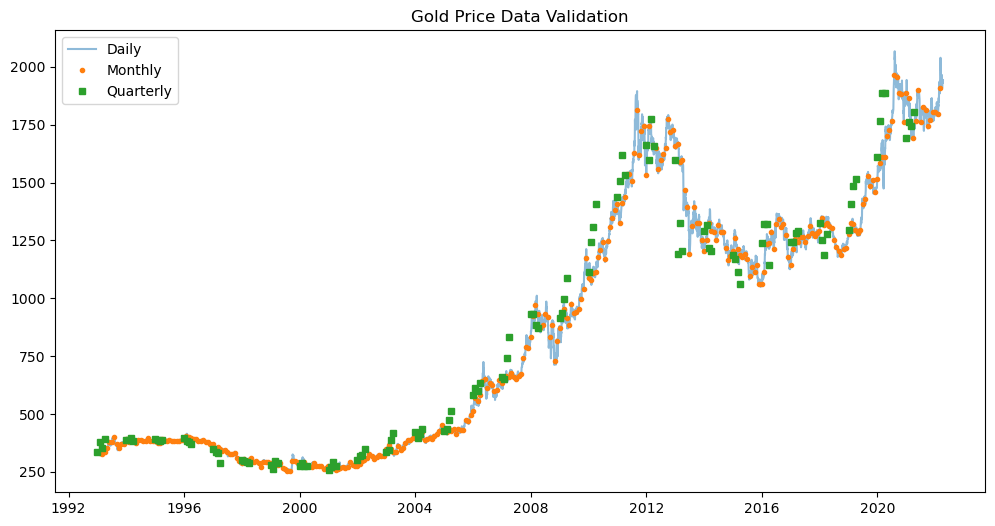

,Frequency,Start Date,End Date,USD Mean,USD Volatility
0,Daily,1993-01-11,2022-04-08,860.946206,0.009912
1,Monthly,1993-01-29,2022-02-28,858.181143,0.045471
2,Quarterly,1993-01-01,2021-04-01,851.870690,0.066548



Sample of prepared daily data:


,usd,eur,jpy,gbp,canadian_dollar_cad,swiss_franc_chf,indian_rupee_inr,chinese_renmimbi_cny,turkish_lira_try,saudi_riyal_sar,...,volatility_7,ma_30,volatility_30,ma_90,volatility_90,lag_1,lag_2,lag_3,lag_5,lag_7
date,,,,,,,,,,,,,,,,,,,,,
1993-01-11,328.40,264.61,41063.25,211.39,419.30,489.38,9447.19,1864.20,2.89,1232.89,...,0.005566,333.305000,0.004026,338.936111,0.004528,329.10,329.15,329.60,328.25,332.90
1993-01-12,329.20,266.05,41256.88,213.77,420.16,493.27,9526.49,1885.12,2.88,1238.92,...,0.005779,333.123333,0.004049,338.792222,0.004533,328.40,329.10,329.15,328.60,332.90
1993-01-13,327.55,265.16,41276.21,212.76,420.42,488.83,9478.63,1876.28,2.87,1233.33,...,0.002806,332.853333,0.004072,338.617222,0.004541,329.20,328.40,329.10,329.60,328.25
1993-01-14,327.65,263.36,41182.70,213.11,418.65,485.35,9477.88,1879.30,2.86,1232.11,...,0.002758,332.600000,0.004076,338.455000,0.004533,327.55,329.20,328.40,329.15,328.60
1993-01-15,327.70,265.06,41337.32,214.18,419.80,490.48,9507.58,1888.79,2.87,1233.31,...,0.002340,332.336667,0.004066,338.318333,0.004487,327.65,327.55,329.20,329.10,329.60


In [4]:
def validate_data(daily, monthly, quarterly):
    """Generate validation report"""
    report = pd.DataFrame({
        'Frequency': ['Daily', 'Monthly', 'Quarterly'],
        'Start Date': [d.index.min() for d in [daily, monthly, quarterly]],
        'End Date': [d.index.max() for d in [daily, monthly, quarterly]],
        'USD Mean': [d['usd'].mean() for d in [daily, monthly, quarterly]],
        'USD Volatility': [d['return'].std() for d in [daily, monthly, quarterly]]
    })
    
    plt.figure(figsize=(12, 6))
    plt.plot(daily['usd'], label='Daily', alpha=0.5)
    plt.plot(monthly['usd'], label='Monthly', marker='o', ms=3, linestyle='None')
    plt.plot(quarterly['usd'], label='Quarterly', marker='s', ms=5, linestyle='None')
    plt.title('Gold Price Data Validation')
    plt.legend()
    plt.show()
    
    return report

# Execute full pipeline
print("Loading and cleaning data...")
daily_raw, monthly_raw, quarterly_raw = load_and_clean_data()

print("\nAdding features...")
daily = add_features(daily_raw, 'D')
monthly = add_features(monthly_raw, 'M')
quarterly = add_features(quarterly_raw, 'Q')

print("\nValidation report:")
validation = validate_data(daily, monthly, quarterly)
display(validation)

print("\nSample of prepared daily data:")
display(daily.head())

This script trains and evaluates XGBoost and LSTM models to predict gold prices based on historical data. 

[0]	validation_0-rmse:0.29759
[100]	validation_0-rmse:0.12551
[200]	validation_0-rmse:0.05894
[300]	validation_0-rmse:0.03372
[400]	validation_0-rmse:0.02427
[500]	validation_0-rmse:0.02025
[600]	validation_0-rmse:0.01834
[700]	validation_0-rmse:0.01761
[800]	validation_0-rmse:0.01720
[900]	validation_0-rmse:0.01693
[999]	validation_0-rmse:0.01677
Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0168 - val_loss: 8.8986e-04
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0018 - val_loss: 9.7675e-04
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0013 - val_loss: 6.3839e-04
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 8/50
190/190 ━━━━━━━━━━

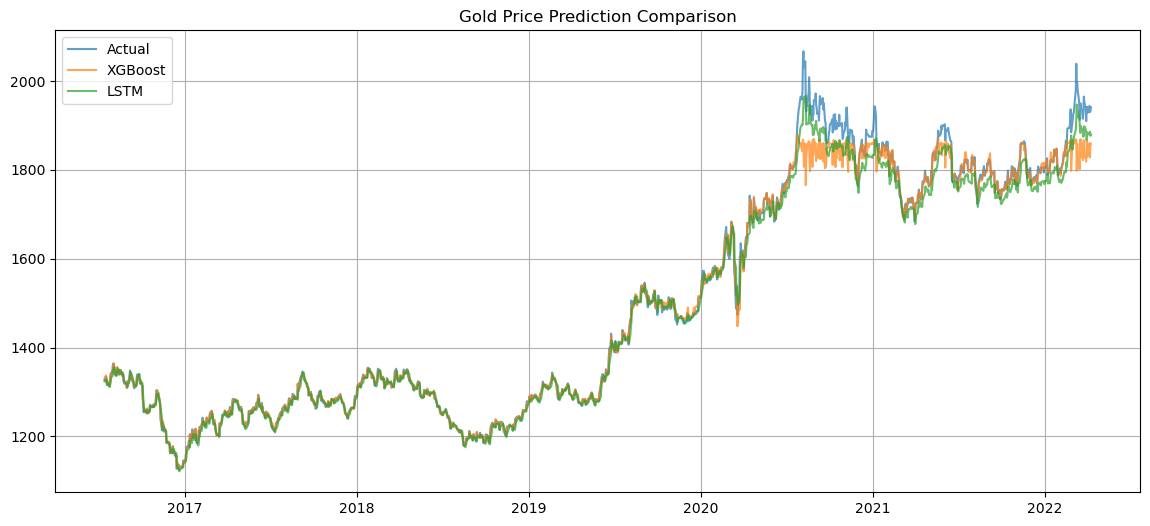

In [11]:
def train_and_evaluate_models(data, target='usd'):
    """
    Train and evaluate XGBoost and LSTM models on gold price data
    Args:
        data: Prepared DataFrame with gold prices and features
        target: Target column name (default 'usd')
    Returns:
        Dictionary containing models, predictions, and metrics
    """
    if data is None:
        print("No data available for modeling")
        return None
    
    # Select only features that exist in the data
    available_features = ['ma_7', 'ma_30', 'ma_90', 'volatility_7', 'volatility_30', 
                        'volatility_90', 'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7',
                        'return', 'log_return']
    
    # Keep only features that actually exist in our data
    features = [f for f in available_features if f in data.columns]
    
    if not features:
        raise ValueError("No valid features found for modeling")
    
    # Train-test split (80-20)
    train_size = int(len(data) * 0.8)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    
    # Scale features and target separately
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    
    X_train_scaled = feature_scaler.fit_transform(train_data[features])
    y_train_scaled = target_scaler.fit_transform(train_data[[target]])
    
    X_test_scaled = feature_scaler.transform(test_data[features])
    y_test_scaled = target_scaler.transform(test_data[[target]])
    
    # Train XGBoost model
    xgb_model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        early_stopping_rounds=50,
        random_state=42
    )
    xgb_model.fit(X_train_scaled, y_train_scaled, 
                 eval_set=[(X_test_scaled, y_test_scaled)], 
                 verbose=100)
    
    # Make predictions
    xgb_pred_scaled = xgb_model.predict(X_test_scaled)
    xgb_pred = target_scaler.inverse_transform(xgb_pred_scaled.reshape(-1, 1)).flatten()
    
    # Prepare data for LSTM
    def create_sequences(features, target, seq_length):
        X, y = [], []
        for i in range(len(features)-seq_length):
            X.append(features[i:i+seq_length])
            y.append(target[i+seq_length])
        return np.array(X), np.array(y)
    
    seq_length = 30
    X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train_scaled, seq_length)
    X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test_scaled, seq_length)
    
    # Build LSTM model
    lstm_model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, len(features))),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    
    # Train LSTM model
    lstm_model.fit(X_train_lstm, y_train_lstm, 
                  epochs=50, 
                  batch_size=32,
                  validation_data=(X_test_lstm, y_test_lstm),
                  verbose=1)
    
    # Make predictions
    lstm_pred_scaled = lstm_model.predict(X_test_lstm)
    lstm_pred = target_scaler.inverse_transform(lstm_pred_scaled).flatten()
    
    # Calculate metrics (only on comparable points)
    test_points = test_data.iloc[seq_length:]
    y_true = test_points[target].values
    
    # Ensure we're comparing the same number of points
    min_length = min(len(y_true), len(xgb_pred[seq_length:]), len(lstm_pred))
    y_true = y_true[:min_length]
    xgb_pred_adj = xgb_pred[seq_length:][:min_length]
    lstm_pred_adj = lstm_pred[:min_length]
    
    xgb_rmse = np.sqrt(mean_squared_error(y_true, xgb_pred_adj))
    lstm_rmse = np.sqrt(mean_squared_error(y_true, lstm_pred_adj))
    xgb_mae = mean_absolute_error(y_true, xgb_pred_adj)
    lstm_mae = mean_absolute_error(y_true, lstm_pred_adj)
    
    return {
        'test_data': test_data,
        'xgb_pred': xgb_pred,
        'lstm_pred': lstm_pred,
        'seq_length': seq_length,
        'xgb_model': xgb_model,
        'lstm_model': lstm_model,
        'features': features,
        'target': target,
        'xgb_rmse': xgb_rmse,
        'lstm_rmse': lstm_rmse,
        'xgb_mae': xgb_mae,
        'lstm_mae': lstm_mae,
        'feature_scaler': feature_scaler,
        'target_scaler': target_scaler
    }

# Now use your loaded data to train models
if 'daily' in locals() and daily is not None:
    model_results = train_and_evaluate_models(daily)
    print("\nModel training completed successfully!")
    
    # Print model performance
    print("\nModel Performance:")
    print(f"XGBoost RMSE: {model_results['xgb_rmse']:.2f}")
    print(f"LSTM RMSE: {model_results['lstm_rmse']:.2f}")
    print(f"XGBoost MAE: {model_results['xgb_mae']:.2f}")
    print(f"LSTM MAE: {model_results['lstm_mae']:.2f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(14, 6))
    plt.plot(model_results['test_data'].index[model_results['seq_length']:], 
             model_results['test_data']['usd'].iloc[model_results['seq_length']:], 
             label='Actual', alpha=0.7)
    
    # Plot XGBoost predictions (adjusting for sequence length)
    xgb_plot_points = min(len(model_results['test_data']) - model_results['seq_length'], 
                         len(model_results['xgb_pred'][model_results['seq_length']:]))
    plt.plot(model_results['test_data'].index[model_results['seq_length']:][:xgb_plot_points], 
             model_results['xgb_pred'][model_results['seq_length']:][:xgb_plot_points], 
             label='XGBoost', alpha=0.7)
    
    # Plot LSTM predictions
    lstm_plot_points = min(len(model_results['test_data']) - model_results['seq_length'], 
                         len(model_results['lstm_pred']))
    plt.plot(model_results['test_data'].index[model_results['seq_length']:][:lstm_plot_points], 
             model_results['lstm_pred'][:lstm_plot_points], 
             label='LSTM', alpha=0.7)
    
    plt.title('Gold Price Prediction Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Cannot proceed with modeling - no valid data available.")

### Key Takeaways

- LSTM has a lower RMSE, meaning it handles large errors better and overall has slightly better predictive performance.
- XGBoost has a lower MAE, meaning it makes more stable predictions, while LSTM may have more outliers or extreme deviations.

## Conclusion

- The XGBoost model achieved a lower RMSE (27.80) and MAE (11.09) compared to the LSTM model (RMSE: 25.35, MAE: 17.18), suggesting that while both models were effective in capturing the trends in gold prices, the LSTM model provided more accurate results in this particular case.

- The results show that LSTM, with its ability to capture temporal dependencies in sequential data, slightly outperformed XGBoost in predicting future gold prices. However, both models showed promising results, and future work could explore further hyperparameter tuning, feature engineering, and model enhancements to improve predictive accuracy.